# Price Analysis New


In [1]:
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
#I want to plot output price vs release date
import matplotlib.pyplot as plt

#read in csv file and convert to pandas dataframe
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, QuantileRegressor



In [2]:

# df = pd.read_csv('datasets/art_analysis_scrape.csv')

# #print the first 5 rows of the dataframe
# # print(df.head())
# print(df.columns)

# # Convert 'release_date' to datetime if it's not already
# #filter out nan values  

# #filter based on 
# df = df[df['Output Price\nUSD/1M Tokens'].notna()]
# df = df[df['Release Date'].notna()]
# df['Release Date'] = pd.to_datetime(df['Release Date'])

# # Convert price to float - handle the case where it might not be a string
# # First check if the column contains strings





# if df['Output Price\nUSD/1M Tokens'].dtype == 'object':
#     df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# else:
#     # If it's already numeric, just ensure it's float type
#     df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].astype(float)

# #clean up data related to lowest price found 




# #make a column of called active parameters if Know active parameters is available use that, otherwise use params
# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
# df['Active Parameters'] = np.where(
#     df['Known Active Parameters'].notna(),
#     df['Known Active Parameters'],
#     df['Parameters']
# )




# #collect output price for models with open licenses
# open_license_df = df[df['License'] == 'Open']
# proprietary_df = df[df['License'] == 'Proprietary']

# Data Processing

In [3]:

df = pd.read_csv('art_analysis_inf_data.csv')
print(df.columns)
#convert price to float
df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

#print the first 5 rows of the datafr

Index(['Model', 'Creator', 'License', 'Context\nWindow',
       'Artificial Analysis\nIntelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
       'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
       'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
       'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
       'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
       'Further\nAnalysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Lowest Output Price Found 

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_44670/2965051322.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


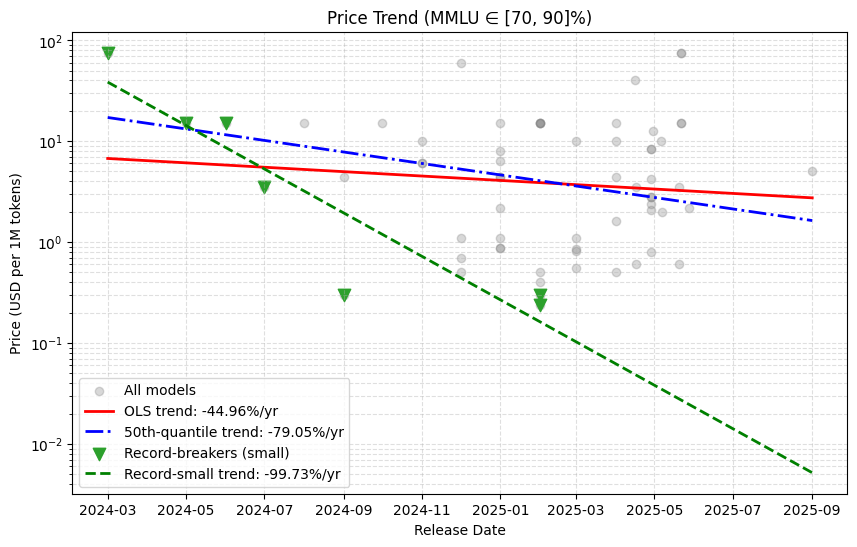

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime

# 0) Bounds & column names
min_mmlu = 70
max_mmlu = 90
mmlu_col = 'MMLU-Pro (Reasoning & Knowledge)'
price_col = 'Output Price\nUSD/1M Tokens'

# 1) Convert MMLU “XX%” → float
df[mmlu_col] = (
    df[mmlu_col].astype(str)
                .str.replace('%','',regex=False)
                .astype(float)
)

# 2) Convert price “$X,XXX” → float
df[price_col] = (
    df[price_col].astype(str)
                 .str.replace('[$,]','',regex=True)
)
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')

# 3) Filter to MMLU range & drop missing
df_sub = df[df[mmlu_col].between(min_mmlu, max_mmlu)].copy()
df_sub = df_sub.dropna(subset=['Release Date', price_col])

# 4) Remove non-positive prices to avoid -inf in log10
df_sub = df_sub[df_sub[price_col] > 0]

# 5) Sort by Release Date & compute ordinal
df_sub = df_sub.sort_values('Release Date')
df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

# 6) Prepare X, y_log
X = df_sub['Date_Ordinal'].values.reshape(-1, 1)
y_log = np.log10(df_sub[price_col].values)

# 7) Fit overall OLS on log(price)
model_all = LinearRegression().fit(X, y_log)

# 8) Fit median (τ=0.5) Quantile Regression on log(price)
quantile = 0.5
qr = QuantileRegressor(quantile=quantile, alpha=0.0).fit(X, y_log)

# 9) Build daily grid for predictions
min_ord = df_sub['Date_Ordinal'].min()
max_ord = df_sub['Date_Ordinal'].max()
x_range = np.arange(min_ord, max_ord + 1)
x_dates = [datetime.fromordinal(int(d)) for d in x_range]

y_ols_log = model_all.predict(x_range.reshape(-1,1))
y_qr_log  = qr.predict(x_range.reshape(-1,1))

# 10) Compute annualized % growth
coef_ols     = model_all.coef_[0]
annual_pct_ols = ((10**coef_ols)**365 - 1) * 100
coef_qr      = qr.coef_[0]
annual_pct_qr  = ((10**coef_qr)**365 - 1) * 100

# 11) Identify “record‐breaking small” (running minima of price)
df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
record_small = df_sub[df_sub['Is_Record_Small']].copy()

# 12) Fit OLS on the record‐small points
X_rec      = record_small['Date_Ordinal'].values.reshape(-1,1)
y_rec_log  = np.log10(record_small[price_col].values)
model_rec  = LinearRegression().fit(X_rec, y_rec_log)
y_rec_log_pred = model_rec.predict(x_range.reshape(-1,1))
coef_rec    = model_rec.coef_[0]
annual_pct_rec = ((10**coef_rec)**365 - 1) * 100

# 13) Plot everything
plt.figure(figsize=(10,6))

# a) All points
plt.scatter(
    df_sub['Release Date'], df_sub[price_col],
    color='gray', alpha=0.3, label='All models'
)

# b) Overall OLS trend
plt.plot(
    x_dates, 10**y_ols_log,
    'r-', lw=2,
    label=f'OLS trend: {annual_pct_ols:.2f}%/yr'
)

# c) Median quantile trend
plt.plot(
    x_dates, 10**y_qr_log,
    'b-.', lw=2,
    label=f'{quantile*100:.0f}th-quantile trend: {annual_pct_qr:.2f}%/yr'
)

# d) Record‐small points
plt.scatter(
    record_small['Release Date'], record_small[price_col],
    color='tab:green', s=80, marker='v',
    label='Record-breakers (small)'
)

# e) Record‐small OLS trend
plt.plot(
    x_dates, 10**y_rec_log_pred,
    'g--', lw=2,
    label=f'Record-small trend: {annual_pct_rec:.2f}%/yr'
)

plt.yscale('log')
plt.xlabel('Release Date')
plt.ylabel('Price (USD per 1M tokens)')
plt.title(f'Price Trend (MMLU ∈ [{min_mmlu}, {max_mmlu}]%)')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.legend()
plt.show()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime

def plot_price_trend_by_mmlu(min_mmlu, max_mmlu, open_license_only=False, quantile=0.2, price_col='Output Price\nUSD/1M Tokens', show_model_names=False):
    """
    Plot price‐per‐1M-token trends for models with MMLU in [min_mmlu, max_mmlu].
    If open_license_only=True, only keep rows where `license_col` contains 'open' (case‐insensitive).
    Assumes `df` is in scope with columns:
      - 'Release Date' (datetime64)
      - 'MMLU-Pro (Reasoning & Knowledge)' (e.g. "75%")
      - price_col (e.g. "$0.50")
      - license_col (e.g. 'License')
    
    Parameters:
      min_mmlu: Minimum MMLU score to include
      max_mmlu: Maximum MMLU score to include
      open_license_only: If True, only include models with open licenses
      quantile: Quantile level for the quantile regression (default: 0.5 for median)
      price_col: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
      show_model_names: If True, displays model names next to record-small points
    """
    # --- column names ---
    mmlu_col    = 'MMLU-Pro (Reasoning & Knowledge)'
    license_col = 'License'   # ← adjust if your CSV uses a different header

    # 1) Work on a copy
    df_work = df.copy()

    # 2) Convert MMLU "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%','',regex=False)
                         .astype(float)
    )

    # 3) Convert price "$X,XXX" → float
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]','',regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

    # 4) Optionally filter to open‐license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 5) Filter to MMLU range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 6) Drop missing Release Date or price, remove non‐positive prices
    df_sub = df_sub.dropna(subset=['Release Date', price_col])
    df_sub = df_sub[df_sub[price_col] > 0]

    # 7) Sort & compute ordinal date
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

    # 8) Prepare regressions on log10(price)
    X     = df_sub['Date_Ordinal'].values.reshape(-1,1)
    y_log = np.log10(df_sub[price_col].values)

    # overall OLS
    ols = LinearRegression().fit(X, y_log)
    # quantile regression with specified quantile
    qr  = QuantileRegressor(quantile=quantile, alpha=0.0).fit(X, y_log)

    # 9) Build daily grid for predictions
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.arange(min_ord, max_ord + 1)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]

    y_ols_log = ols.predict(x_range.reshape(-1,1))
    y_qr_log  = qr.predict(x_range.reshape(-1,1))

    # 10) Compute annualized % growth and price decrease factor
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_factor_ols = 1 / (10**ols.coef_[0])**365
    
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100
    annual_factor_qr = 1 / (10**qr.coef_[0])**365

    # 11) "Record‐small" = running minima of price
    df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # OLS on those
    X_rec         = record_small['Date_Ordinal'].values.reshape(-1,1)
    y_rec_log     = np.log10(record_small[price_col].values)
    rec_ols       = LinearRegression().fit(X_rec, y_rec_log)
    y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
    annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
    annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365

    # 12) Plot
    plt.figure(figsize=(10,6))
    # all
    plt.scatter(df_sub['Release Date'], df_sub[price_col],
                color='gray', alpha=0.3, label='All models')
    # OLS trend
    plt.plot(x_dates, 10**y_ols_log, 'r-', lw=2,
             label=f'OLS trend: {annual_pct_ols:.2f}%/yr ({annual_factor_ols:.2f}x cheaper/yr)')
    # specified quantile
    plt.plot(x_dates, 10**y_qr_log, 'b-.', lw=2,
             label=f'{quantile*100:.0f}th-quantile: {annual_pct_qr:.2f}%/yr ({annual_factor_qr:.2f}x cheaper/yr)')
    # record-small points
    plt.scatter(record_small['Release Date'], record_small[price_col],
                color='tab:green', s=80, marker='v',
                label='Record-small points')
    # record-small trend
    plt.plot(x_dates, 10**y_rec_log_pred, 'g--', lw=2,
             label=f'Record-small trend: {annual_pct_rec:.2f}%/yr ({annual_factor_rec:.2f}x cheaper/yr)')
    
    # Add model names if requested
    if show_model_names:
        for idx, row in record_small.iterrows():
            plt.annotate(row['Model'], 
                         (row['Release Date'], row[price_col]),
                         xytext=(5, 5), 
                         textcoords='offset points',
                         fontsize=8)

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')
    lic_label = 'open‐license only' if open_license_only else 'all licenses'
    plt.title(f'Price Trend (MMLU ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}) \n {price_col}')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()

# Example usage:
# plot_price_trend_by_mmlu(50, 70, open_license_only=True, quantile=0.2)

# Look At Trend Across All Groups

## Low End Model Group

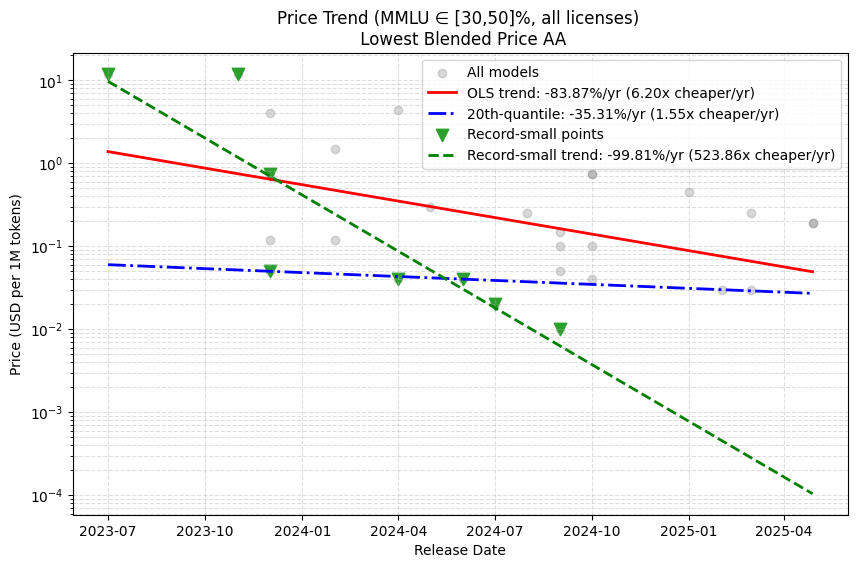

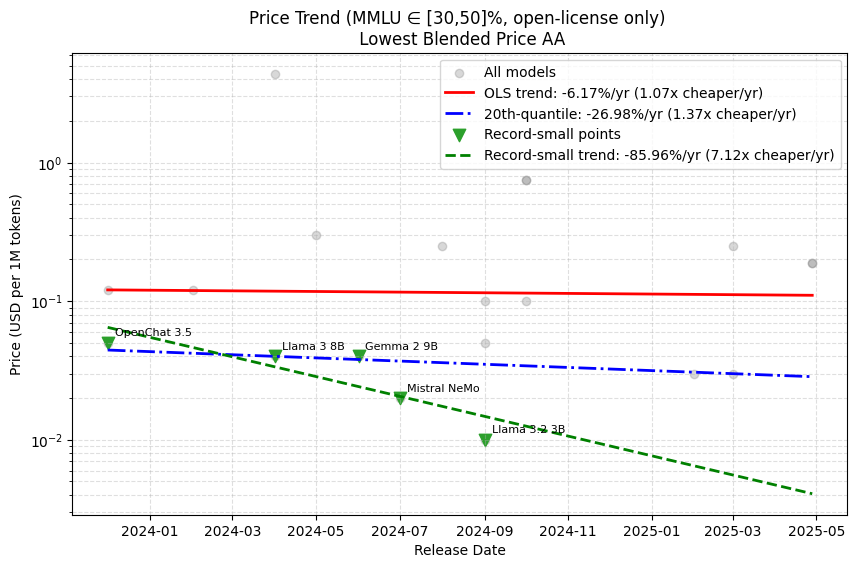

In [6]:
plot_price_trend_by_mmlu(30, 50, open_license_only=False, quantile=0.2, price_col="Lowest Blended Price AA")
plot_price_trend_by_mmlu(30, 50, open_license_only=True, quantile=0.2, price_col="Lowest Blended Price AA", show_model_names=True)
# plot_price_trend_by_mmlu(30, 50, open_license_only=True, quantile=0.2)

## Medium Level Trend

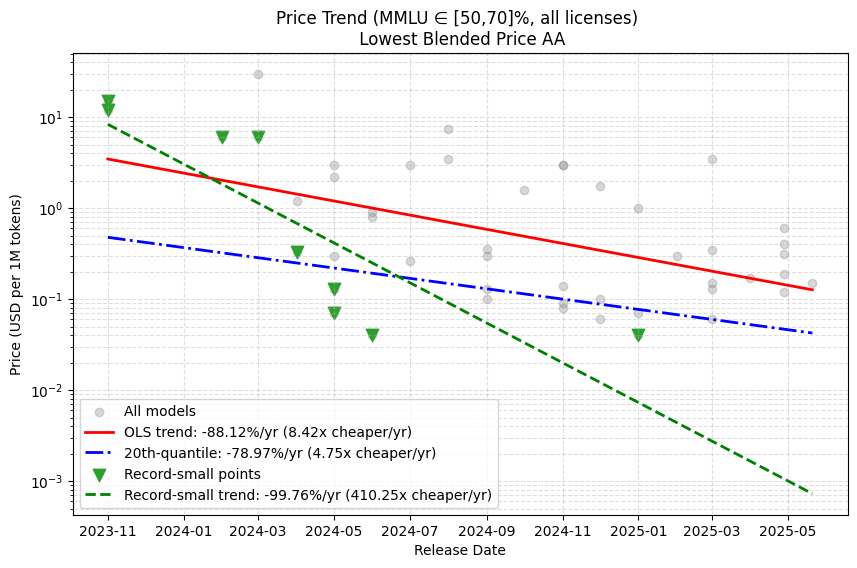

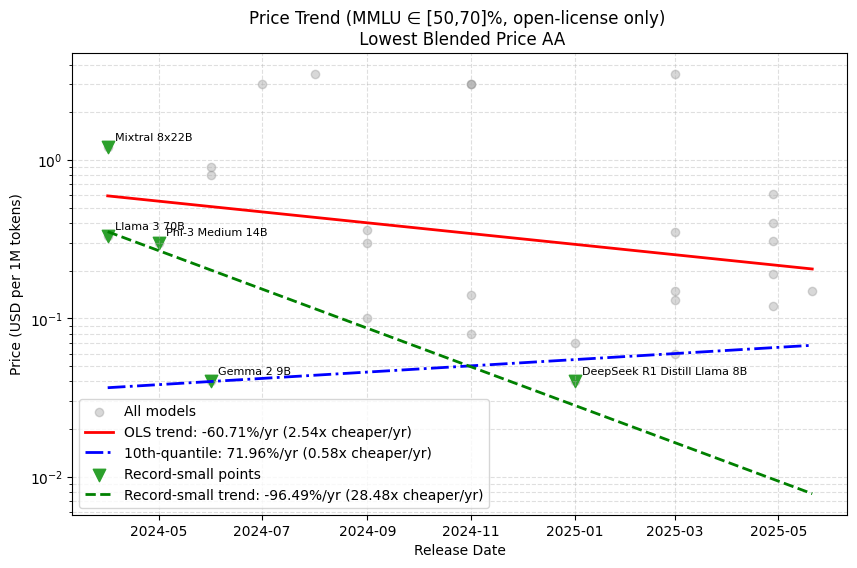

In [7]:
plot_price_trend_by_mmlu(50, 70, open_license_only=False, quantile=0.2, price_col="Lowest Blended Price AA")
plot_price_trend_by_mmlu(50, 70, open_license_only=True, quantile=0.1, price_col="Lowest Blended Price AA", show_model_names=True)

## High End Model Group

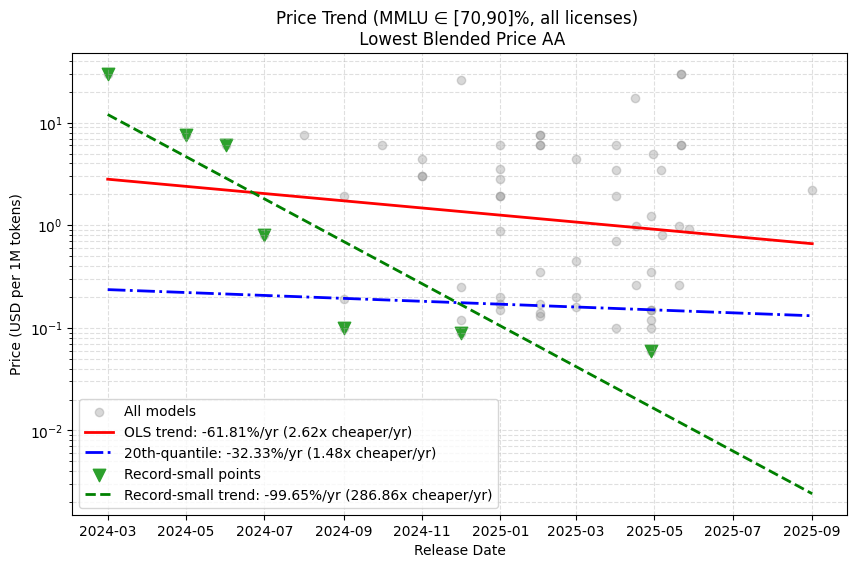

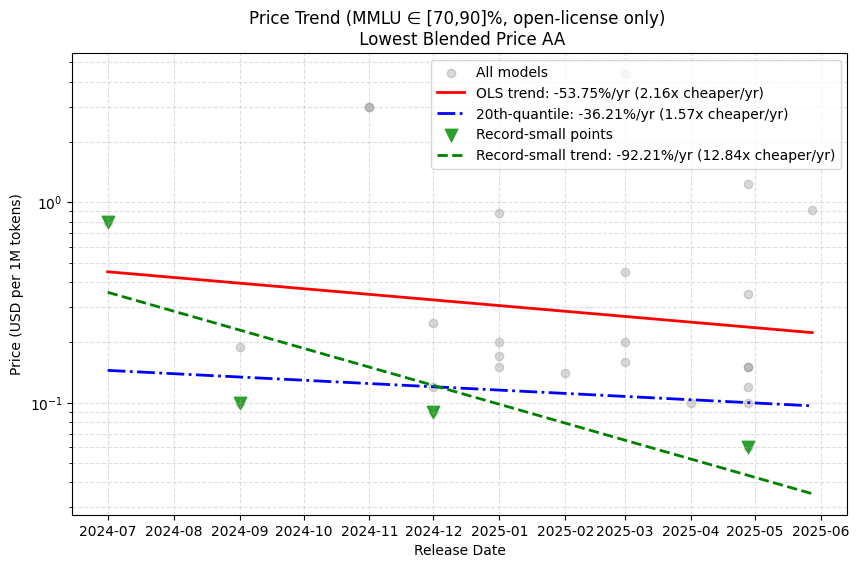

In [8]:
plot_price_trend_by_mmlu(70, 90, open_license_only=False, quantile=0.2, price_col="Lowest Blended Price AA")
plot_price_trend_by_mmlu(70, 90, open_license_only=True, quantile=0.2, price_col="Lowest Blended Price AA")
# plot_price_trend_by_mmlu(70, 90, open_license_only=True, quantile=0.2)

## Graph Amalgamation

In [ ]:
I want to graph the trend lines for the record small points in each MMLU range ie 30-50, 50-70, 70-90 along with th record small points for each group. The x axis should be release date and the y axis shoudl be price per 1M tokens 

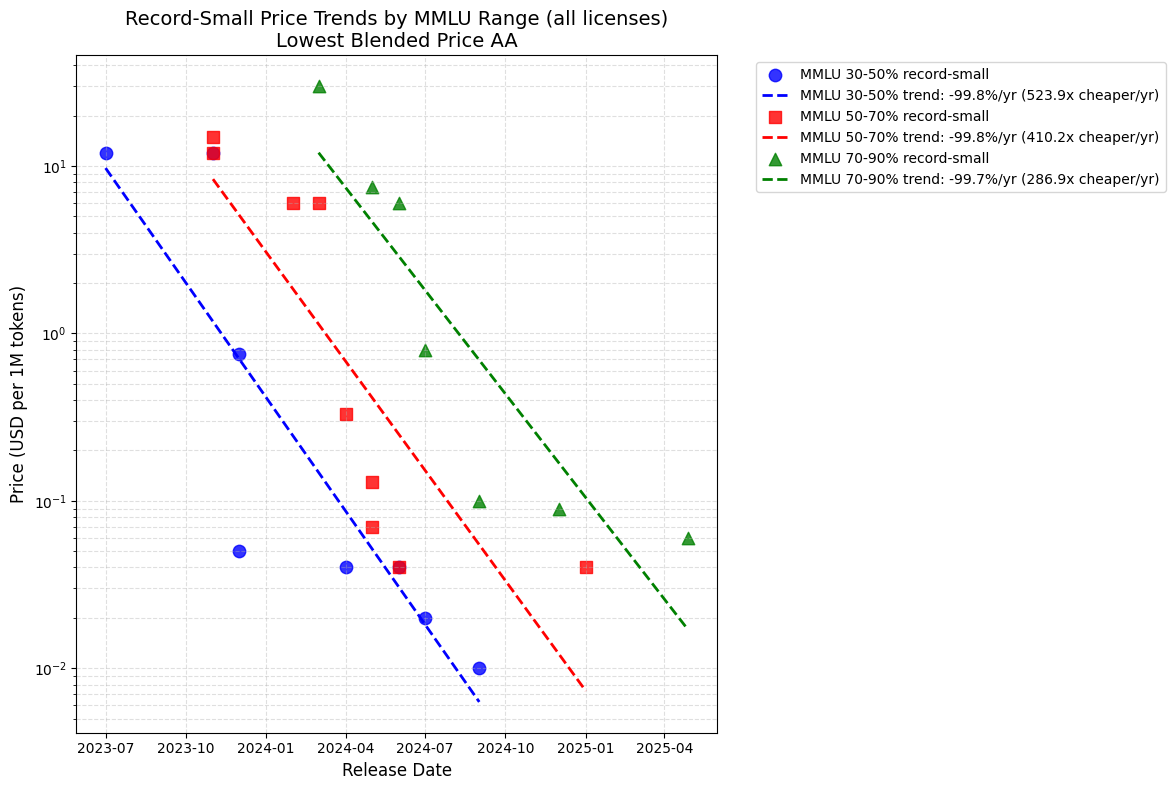

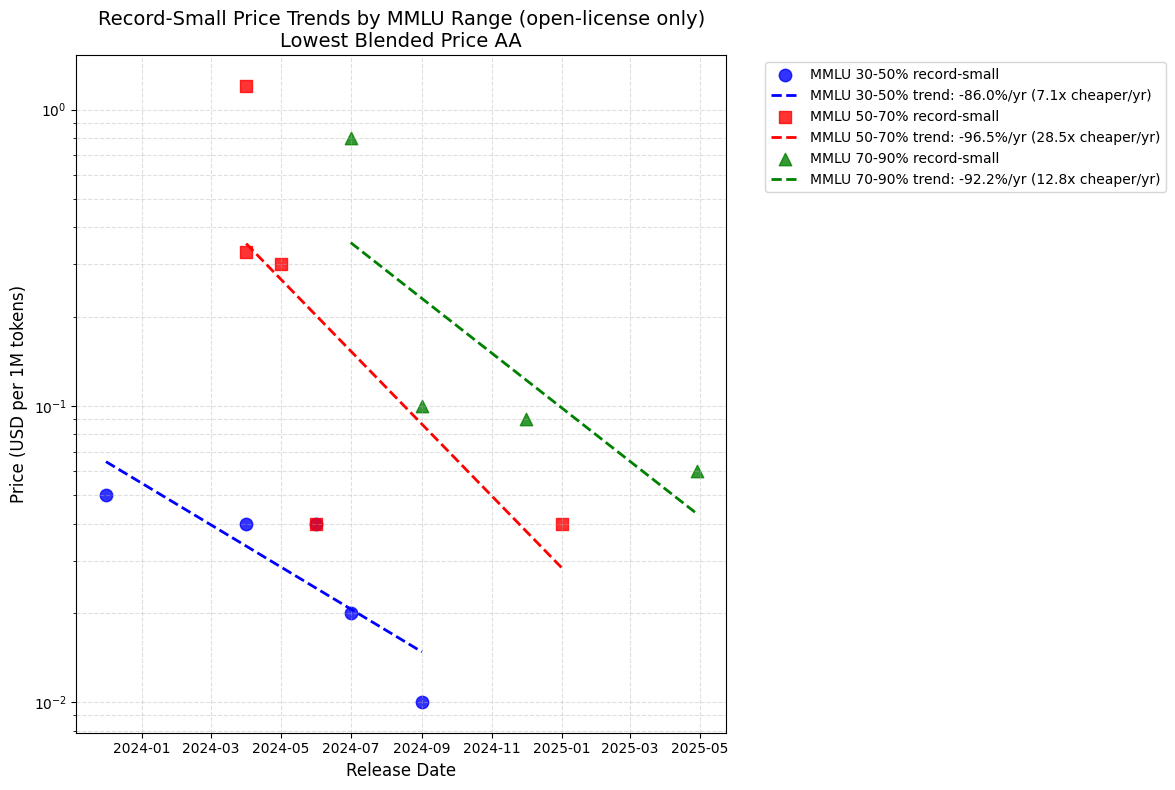

In [23]:
def plot_combined_record_small_trends(open_license_only=False, price_col='Lowest Blended Price AA', show_model_names=False):
    """
    Plot record-small points and their trend lines for three MMLU ranges (30-50, 50-70, 70-90) 
    on a single graph.
    
    Parameters:
      open_license_only: If True, only include models with open licenses
      price_col: Column name for price data (default: 'Lowest Blended Price AA')
      show_model_names: If True, displays model names next to record-small points
    """
    # Define MMLU ranges and colors
    mmlu_ranges = [(30, 50), (50, 70), (70, 90)]
    colors = ['blue', 'red', 'green']
    markers = ['o', 's', '^']
    
    # --- column names ---
    mmlu_col = 'MMLU-Pro (Reasoning & Knowledge)'
    license_col = 'License'
    
    plt.figure(figsize=(12, 8))
    
    # Store all data for setting axis limits
    all_dates = []
    all_prices = []
    
    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        color = colors[i]
        marker = markers[i]
        
        # 1) Work on a copy
        df_work = df.copy()

        # 2) Convert MMLU "XX%" → float
        df_work[mmlu_col] = (
            df_work[mmlu_col].astype(str)
                             .str.replace('%','',regex=False)
                             .astype(float)
        )

        # 3) Convert price "$X,XXX" → float
        df_work[price_col] = (
            df_work[price_col].astype(str)
                             .str.replace('[$,]','',regex=True)
        )
        df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

        # 4) Optionally filter to open‐license only
        if open_license_only:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]

        # 5) Filter to MMLU range
        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

        # 6) Drop missing Release Date or price, remove non‐positive prices
        df_sub = df_sub.dropna(subset=['Release Date', price_col])
        df_sub = df_sub[df_sub[price_col] > 0]

        # Skip if no data
        if len(df_sub) == 0:
            continue

        # 7) Sort & compute ordinal date
        df_sub = df_sub.sort_values('Release Date')
        df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

        # 8) "Record‐small" = running minima of price
        df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
        record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
        # Skip if no record small points
        if len(record_small) == 0:
            continue

        # 9) Linear regression on record small points (log scale)
        X_rec = record_small['Date_Ordinal'].values.reshape(-1,1)
        y_rec_log = np.log10(record_small[price_col].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        
        # 10) Create prediction line
        min_ord, max_ord = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(min_ord, max_ord + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
        
        # 11) Calculate annual decrease rate
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365

        # 12) Plot record small points
        plt.scatter(record_small['Release Date'], record_small[price_col],
                   color=color, s=80, marker=marker, alpha=0.8,
                   label=f'MMLU {min_mmlu}-{max_mmlu}% record-small')
        
        # 13) Plot trend line
        plt.plot(x_dates, 10**y_rec_log_pred, color=color, linestyle='--', linewidth=2,
                label=f'MMLU {min_mmlu}-{max_mmlu}% trend: {annual_pct_rec:.1f}%/yr ({annual_factor_rec:.1f}x cheaper/yr)')
        
        # 14) Add model names if requested
        if show_model_names:
            for idx, row in record_small.iterrows():
                plt.annotate(row['Model'], 
                           (row['Release Date'], row[price_col]),
                           xytext=(5, 5), 
                           textcoords='offset points',
                           fontsize=8,
                           color=color)
        
        # Store data for axis limits
        all_dates.extend(record_small['Release Date'].tolist())
        all_prices.extend(record_small[price_col].tolist())
    
    # 15) Formatting
    plt.yscale('log')
    plt.xlabel('Release Date', fontsize=12)
    plt.ylabel('Price (USD per 1M tokens)', fontsize=12)
    lic_label = 'open‐license only' if open_license_only else 'all licenses'
    plt.title(f'Record-Small Price Trends by MMLU Range ({lic_label})\n{price_col}', fontsize=14)
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Usage examples:
# For all licenses:
plot_combined_record_small_trends(open_license_only=False, price_col="Lowest Blended Price AA")

# For open licenses only with model names:
plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", show_model_names=False)

## Parameter Trends

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime

def plot_params_small_trend_by_mmlu(min_mmlu, max_mmlu, open_license_only=False, benchmark_name='MMLU-Pro (Reasoning & Knowledge)', use_active_params=False, show_model_names=False):
    """
    Plot number-of-parameters (in billions) vs. release date for models
    with benchmark score ∈ [min_mmlu, max_mmlu], and highlight the record-small trend
    (running minima of model size).
    
    Parameters:
    - min_mmlu, max_mmlu: numeric bounds on benchmark score (%)
    - open_license_only: if True, only include rows where 'License' contains 'open'
    - benchmark_name: name of the benchmark column to use (default: 'MMLU-Pro (Reasoning & Knowledge)')
    - use_active_params: if True, use 'Active Parameters' column instead of 'Parameters'
    - show_model_names: if True, display model names next to record-small points
    
    Assumes `df` is in scope with columns:
      - 'Release Date' (datetime64)
      - benchmark_name (e.g. '75%')
      - 'Parameters' or 'Active Parameters' (absolute count)
      - 'License' (string)
    """
    # column names
    mmlu_col    = benchmark_name
    param_col   = 'Active Parameters' if use_active_params else 'Parameters'  # choose parameter column
    license_col = 'License'             # adjust if needed

    # work on a copy
    df_work = df.copy()

    # 1) Convert benchmark score "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%', '', regex=False)
                         .astype(float)
    )

    # 2) Convert parameter counts → numeric; scale to billions
    df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')
    df_work['Params_B'] = df_work[param_col]

    # 3) Optionally filter to open-licensed models
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 4) Filter to benchmark score range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 5) Drop missing dates or sizes; remove non-positive sizes
    df_sub = df_sub.dropna(subset=['Release Date', 'Params_B'])
    df_sub = df_sub[df_sub['Params_B'] > 0]

    # 6) Sort & compute ordinal dates
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # Check if we have enough data points to proceed
    if len(df_sub) < 1:
        print(f"Warning: No data points found for the specified criteria. "
              f"MMLU range: [{min_mmlu}, {max_mmlu}], Open license only: {open_license_only}, "
              f"Using {param_col}")
        return
    
    # 7) Prepare X, y (log10 of Params_B)
    X     = df_sub['Date_Ordinal'].values.reshape(-1, 1)
    y_log = np.log10(df_sub['Params_B'].values)

    # 8) Fit overall OLS & median QuantileRegressor
    ols = LinearRegression().fit(X, y_log)
    qr  = QuantileRegressor(quantile=0.5, alpha=0.0).fit(X, y_log)

    # 9) Build daily grid for predictions
    lo, hi    = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range   = np.arange(lo, hi + 1)
    x_dates   = [datetime.fromordinal(int(d)) for d in x_range]
    y_ols_log = ols.predict(x_range.reshape(-1, 1))
    y_qr_log  = qr.predict(x_range.reshape(-1, 1))

    # 10) Annualized growth rates
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100
    
    # Calculate factor decreases (for negative percentages)
    factor_ols = 1 / (1 + annual_pct_ols/100) if annual_pct_ols < 0 else None
    factor_qr = 1 / (1 + annual_pct_qr/100) if annual_pct_qr < 0 else None

    # 11) Identify record-small points (running minima of size)
    df_sub['Is_Record_Small'] = df_sub['Params_B'].cummin() == df_sub['Params_B']
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # 12) Fit OLS on record-small points
    X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
    y_rec_log = np.log10(record_small['Params_B'].values)
    
    # Only proceed with record small trend if we have at least one data point
    if len(record_small) >= 1:
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        factor_rec = 1 / (1 + annual_pct_rec/100) if annual_pct_rec < 0 else None
    else:
        rec_ols = None
        y_rec_log_pred = None
        annual_pct_rec = None
        factor_rec = None

    # 13) Plot
    plt.figure(figsize=(10, 6))

    # a) All models
    plt.scatter(
        df_sub['Release Date'], df_sub['Params_B'],
        color='gray', alpha=0.3, label='All models'
    )
    # b) Overall OLS trend
    ols_label = f'OLS trend: {annual_pct_ols:.2f}%/yr'
    if factor_ols:
        ols_label += f' ({factor_ols:.2f}× decrease/yr)'
    plt.plot(
        x_dates, 10**y_ols_log,
        'r-', lw=2, label=ols_label
    )
    # c) Median quantile trend
    qr_label = f'50th-quantile trend: {annual_pct_qr:.2f}%/yr'
    if factor_qr:
        qr_label += f' ({factor_qr:.2f}× decrease/yr)'
    plt.plot(
        x_dates, 10**y_qr_log,
        'b-.', lw=2, label=qr_label
    )
    
    # d & e) Only plot record small trend if we have data
    if len(record_small) >= 1:
        # d) Record-small points
        plt.scatter(
            record_small['Release Date'], record_small['Params_B'],
            color='tab:green', s=80, marker='v',
            label='Record-small points'
        )
        
        # Add model names if requested
        if show_model_names and 'Model' in record_small.columns:
            for i, row in record_small.iterrows():
                plt.annotate(
                    row['Model'],
                    (row['Release Date'], row['Params_B']),
                    xytext=(5, 0),
                    textcoords='offset points',
                    fontsize=8,
                    va='center'
                )
                
        # e) Record-small OLS trend
        if rec_ols is not None:
            rec_label = f'Record-small trend: {annual_pct_rec:.2f}%/yr'
            if factor_rec:
                rec_label += f' ({factor_rec:.2f}× decrease/yr)'
            plt.plot(
                x_dates, 10**y_rec_log_pred,
                'g--', lw=2,
                label=rec_label
            )

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Parameters (billion)')
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    param_type = 'Active Parameters' if use_active_params else 'Parameters'
    benchmark_short = benchmark_name.split(' ')[0]
    plt.title(f'Model-size Trend ({benchmark_short} ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}, {param_type})')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()


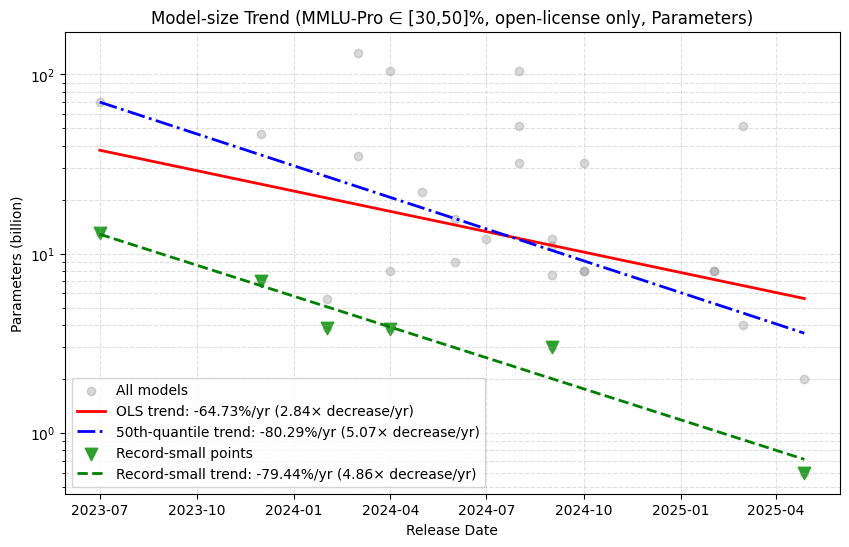

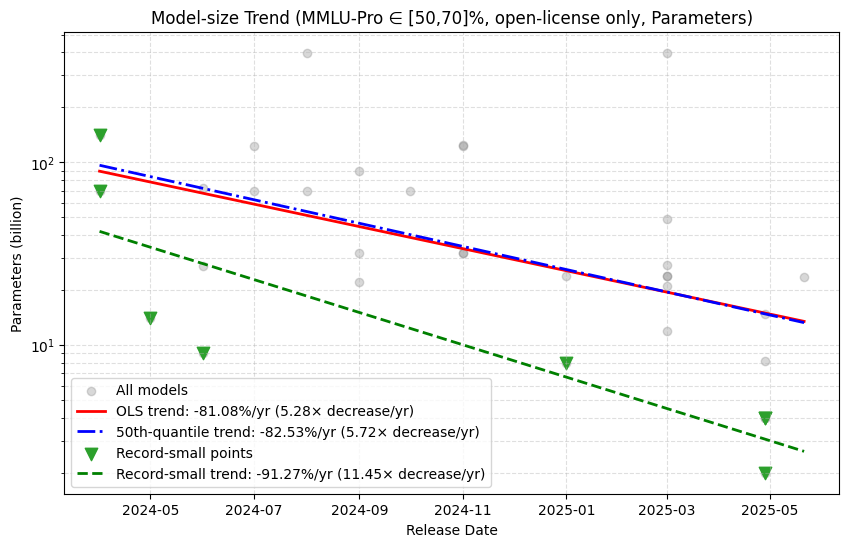

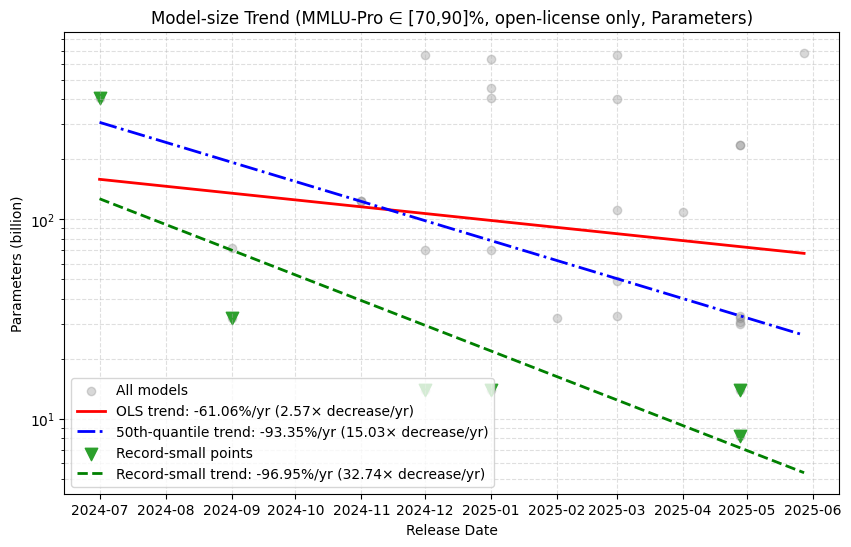

In [10]:
plot_params_small_trend_by_mmlu(30, 50, open_license_only=True, use_active_params=False)
plot_params_small_trend_by_mmlu(50, 70, open_license_only=True, use_active_params=False)
plot_params_small_trend_by_mmlu(70, 90, open_license_only=True, use_active_params=False)


## Active Parameters

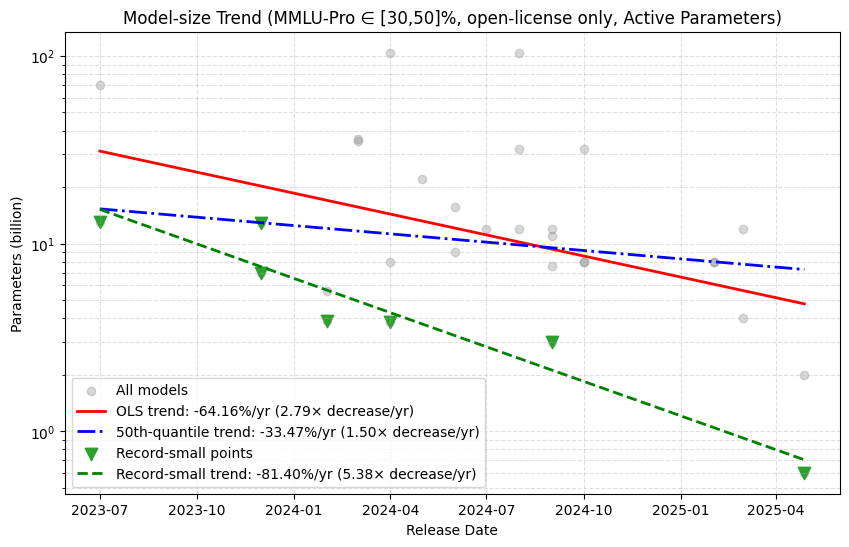

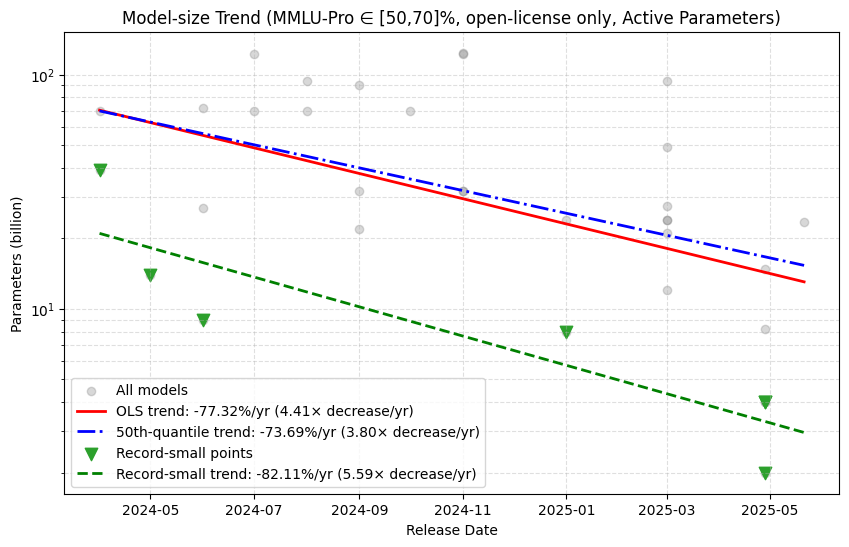

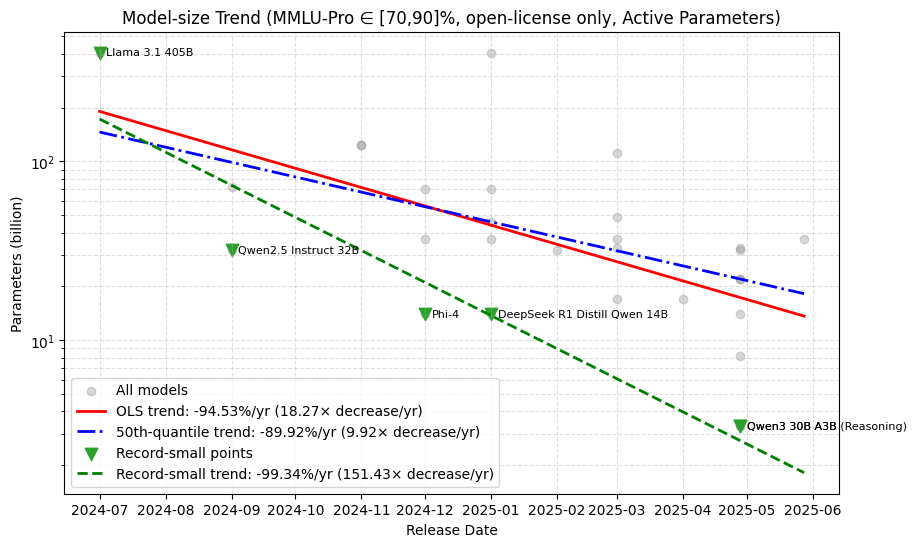

In [11]:
plot_params_small_trend_by_mmlu(30, 50, open_license_only=True, use_active_params=True)
plot_params_small_trend_by_mmlu(50, 70, open_license_only=True, use_active_params=True)
plot_params_small_trend_by_mmlu(70, 90, open_license_only=True, use_active_params=True, show_model_names=True)


## Combined Trend in Active Parameters 

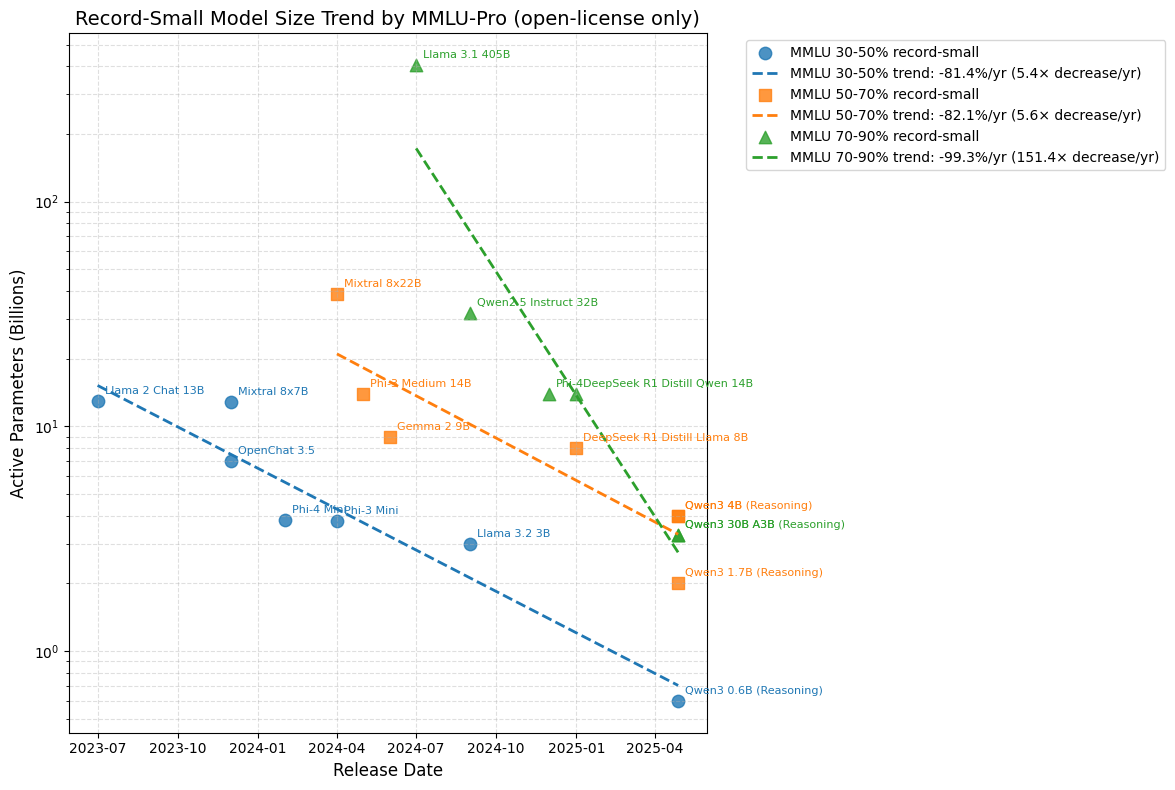

In [26]:
def plot_combined_params_trend(open_license_only=False, use_active_params=True, show_model_names=False, benchmark_name='MMLU-Pro (Reasoning & Knowledge)'):
    """
    Plot record-small parameter trends for three MMLU ranges (30-50, 50-70, 70-90) 
    on a single graph.
    
    Parameters:
      - open_license_only: if True, only include models where 'License' contains 'open'
      - use_active_params: if True, use 'Active Parameters'; else, use 'Parameters'
      - show_model_names: if True, display model names next to record-small points
      - benchmark_name: name of the benchmark column to use
    """
    # Define MMLU ranges and plotting styles
    mmlu_ranges = [(30, 50), (50, 70), (70, 90)]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Matplotlib default colors
    markers = ['o', 's', '^']
    
    # Setup plot
    plt.figure(figsize=(12, 8))
    
    # Column names
    mmlu_col = benchmark_name
    param_col = 'Active Parameters' if use_active_params else 'Parameters'
    license_col = 'License'

    # Loop over MMLU ranges
    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        # --- Data Preparation ---
        df_work = df.copy()

        df_work[mmlu_col] = (
            df_work[mmlu_col].astype(str)
                             .str.replace('%', '', regex=False)
                             .astype(float)
        )
        
        df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')
        df_work['Params_B'] = df_work[param_col]

        if open_license_only:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]

        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()
        
        df_sub = df_sub.dropna(subset=['Release Date', 'Params_B'])
        df_sub = df_sub[df_sub['Params_B'] > 0]
        
        if len(df_sub) < 2:
            print(f"Not enough data for MMLU range {min_mmlu}-{max_mmlu} to plot a trend.")
            continue
            
        # --- Record-Small Calculation & Regression ---
        df_sub = df_sub.sort_values('Release Date')
        df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
        
        df_sub['Is_Record_Small'] = df_sub['Params_B'].cummin() == df_sub['Params_B']
        record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
        if len(record_small) < 2:
            print(f"Not enough record-small points for MMLU range {min_mmlu}-{max_mmlu} to plot a trend.")
            continue

        X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
        y_rec_log = np.log10(record_small['Params_B'].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        
        lo, hi = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(lo, hi + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))

        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        factor_rec_str = ""
        if annual_pct_rec < 0:
            factor_rec = 1 / (1 + annual_pct_rec / 100)
            factor_rec_str = f' ({factor_rec:.1f}× decrease/yr)'
        
        # --- Plotting ---
        plt.scatter(
            record_small['Release Date'], record_small['Params_B'],
            color=colors[i], s=80, marker=markers[i], alpha=0.8,
            label=f'MMLU {min_mmlu}-{max_mmlu}% record-small'
        )
        
        plt.plot(
            x_dates, 10**y_rec_log_pred,
            color=colors[i], linestyle='--', linewidth=2,
            label=f'MMLU {min_mmlu}-{max_mmlu}% trend: {annual_pct_rec:.1f}%/yr{factor_rec_str}'
        )

        if show_model_names and 'Model' in record_small.columns:
            for _, row in record_small.iterrows():
                plt.annotate(
                    row['Model'], (row['Release Date'], row['Params_B']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color=colors[i]
                )
    
    # --- Final Plot Formatting ---
    plt.yscale('log')
    plt.xlabel('Release Date', fontsize=12)
    param_type_label = 'Active Parameters' if use_active_params else 'Parameters'
    plt.ylabel(f'{param_type_label} (Billions)', fontsize=12)
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    benchmark_short = benchmark_name.split(' ')[0]
    plt.title(f'Record-Small Model Size Trend by {benchmark_short} ({lic_label})', fontsize=14)
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage for open-license models, showing model names
plot_combined_params_trend(open_license_only=True, use_active_params=True, show_model_names=True)

# Example usage for all models
# plot_combined_params_trend(open_license_only=False, use_active_params=True, show_model_names=True)

# Parameters Per Dollar

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime

def plot_params_small_trend_by_mmlu(min_mmlu,
                                    max_mmlu,
                                    open_license_only=False,
                                    benchmark_name='MMLU-Pro (Reasoning & Knowledge)',
                                    use_active_params=False,
                                    price_column='Output Price\nUSD/1M Tokens'):
    """
    Same inputs as before, but y‐axis = dollars per parameter:
      cost_per_param = (Output Price $/1M tokens) / (# parameters)
    
    Parameters:
    - min_mmlu, max_mmlu: numeric bounds on benchmark_name (%)
    - open_license_only: if True, only include rows where 'License' contains 'open'
    - benchmark_name: column name for the benchmark (default MMLU-Pro)
    - use_active_params: if True, use 'Active Parameters' instead of 'Parameters'
    - price_column: column to use for price data (default 'Output Price\nUSD/1M Tokens')
    """
    # 0) Column keys
    mmlu_col    = benchmark_name
    price_col   = price_column
    param_col   = 'Active Parameters' if use_active_params else 'Parameters'
    license_col = 'License'

    df_work = df.copy()

    # 1) Parse benchmark → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%','',regex=False)
                         .astype(float)
    )
    # 2) Parse price → float ($ per 1M tokens)
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]','',regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    # 3) Parse params → float
    df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')

    # 4) Optional license filter
    if open_license_only:
        df_work = df_work[
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 5) Filter by benchmark range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 6) Drop missing / non-positive
    df_sub = df_sub.dropna(subset=['Release Date', price_col, param_col])
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[param_col] > 0)]

    # 7) Compute cost per parameter
    df_sub['Cost_per_Param'] = df_sub[price_col] / df_sub[param_col]

    # 8) Sort & date ordinals
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

    # 9) Prepare X, y = log10(cost_per_param)
    X     = df_sub['Date_Ordinal'].values.reshape(-1,1)
    y_log = np.log10(df_sub['Cost_per_Param'].values)

    # 10) Fit overall OLS & median QuantileRegressor
    ols = LinearRegression().fit(X, y_log)
    qr  = QuantileRegressor(quantile=0.5, alpha=0.0).fit(X, y_log)

    # 11) Build prediction grid
    lo, hi    = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range   = np.arange(lo, hi+1)
    x_dates   = [datetime.fromordinal(int(d)) for d in x_range]
    y_ols_log = ols.predict(x_range.reshape(-1,1))
    y_qr_log  = qr.predict(x_range.reshape(-1,1))

    # 12) Compute annualized % growth
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100
    
    # Calculate factor decrease per year
    factor_ols = 1 / (1 + annual_pct_ols/100) if annual_pct_ols < 0 else 1 + annual_pct_ols/100
    factor_qr = 1 / (1 + annual_pct_qr/100) if annual_pct_qr < 0 else 1 + annual_pct_qr/100

    # 13) Identify "record‐small" cost points
    df_sub['Is_Record_Small'] = df_sub['Cost_per_Param'].cummin() == df_sub['Cost_per_Param']
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # 14) OLS on record‐small
    X_rec          = record_small['Date_Ordinal'].values.reshape(-1,1)
    y_rec_log      = np.log10(record_small['Cost_per_Param'].values)
    rec_ols        = LinearRegression().fit(X_rec, y_rec_log)
    y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
    annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
    
    # Calculate factor decrease for record-small trend
    factor_rec = 1 / (1 + annual_pct_rec/100) if annual_pct_rec < 0 else 1 + annual_pct_rec/100

    # 15) Plot
    plt.figure(figsize=(10,6))
    # all models
    plt.scatter(df_sub['Release Date'], df_sub['Cost_per_Param'],
                color='gray', alpha=0.3, label='All models')
    # overall OLS
    plt.plot(x_dates, 10**y_ols_log, 'r-', lw=2,
             label=f'OLS trend: {annual_pct_ols:.2f}%/yr ({factor_ols:.2f}x/yr)')
    # median quantile
    plt.plot(x_dates, 10**y_qr_log, 'b-.', lw=2,
             label=f'50th-quantile: {annual_pct_qr:.2f}%/yr ({factor_qr:.2f}x/yr)')
    # record‐small points
    plt.scatter(record_small['Release Date'], record_small['Cost_per_Param'],
                color='tab:green', s=80, marker='v',
                label='Record-small cost')
    # record‐small trend
    plt.plot(x_dates, 10**y_rec_log_pred, 'g--', lw=2,
             label=f'Record-small trend: {annual_pct_rec:.2f}%/yr ({factor_rec:.2f}x/yr)')

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Cost per parameter\n($ per 1M tokens ÷ # params)')
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    price_type = price_col.replace('\n', ' ')
    plt.title(f'Cost-per-Param Trend ({mmlu_col} ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}, {price_type}) \n active params: {use_active_params}')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()

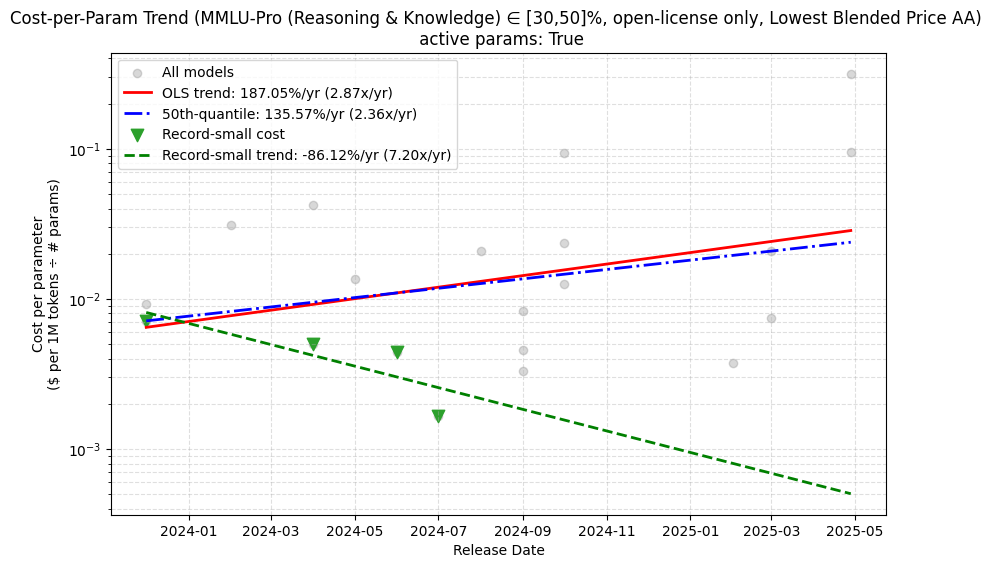

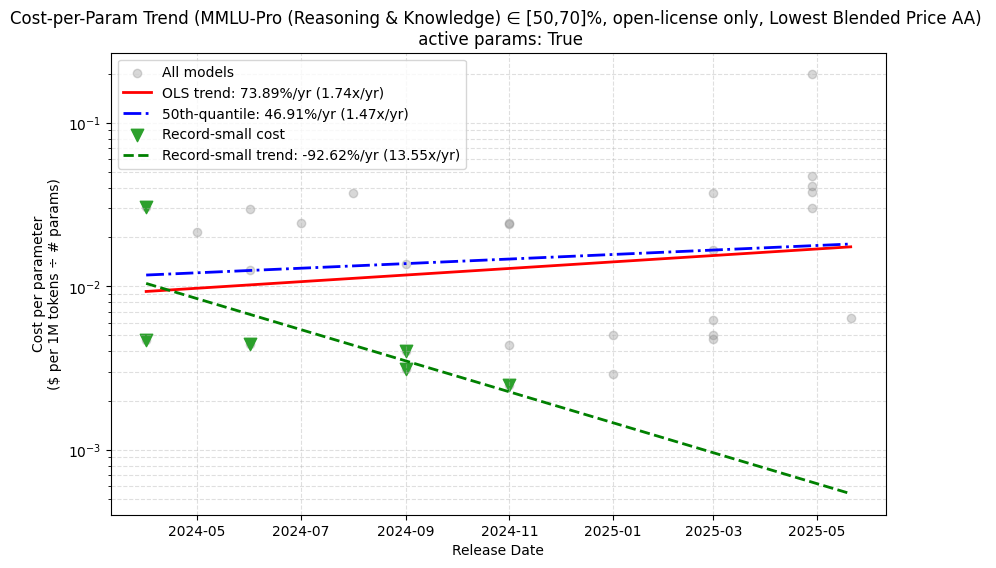

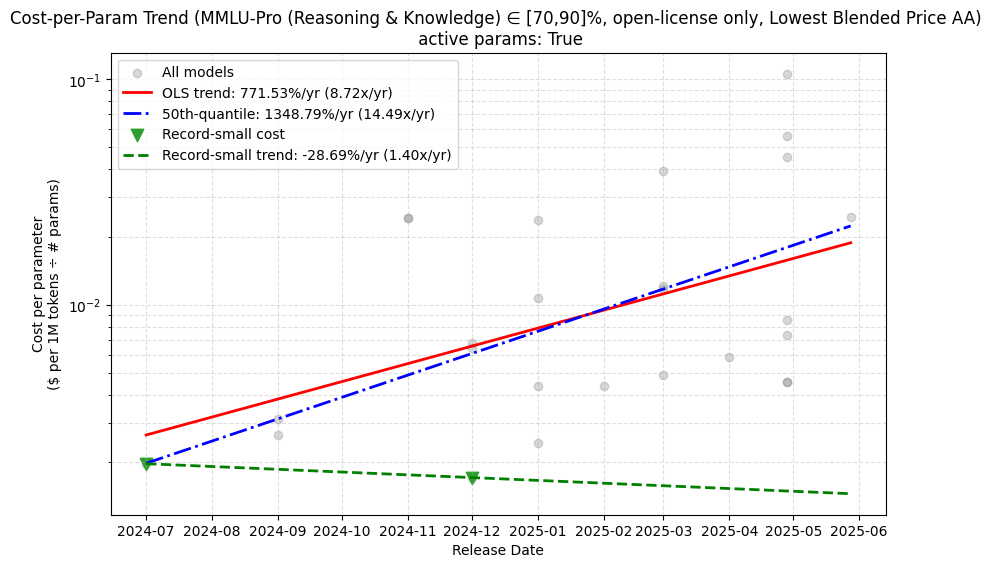

In [25]:
plot_params_small_trend_by_mmlu(30, 50, open_license_only=True, use_active_params=True, price_column="Lowest Blended Price AA")
plot_params_small_trend_by_mmlu(50, 70, open_license_only=True, use_active_params=True, price_column="Lowest Blended Price AA")
plot_params_small_trend_by_mmlu(70, 90, open_license_only=True, use_active_params=True, price_column="Lowest Blended Price AA")

## Combined Graph of Cost Per Parameter

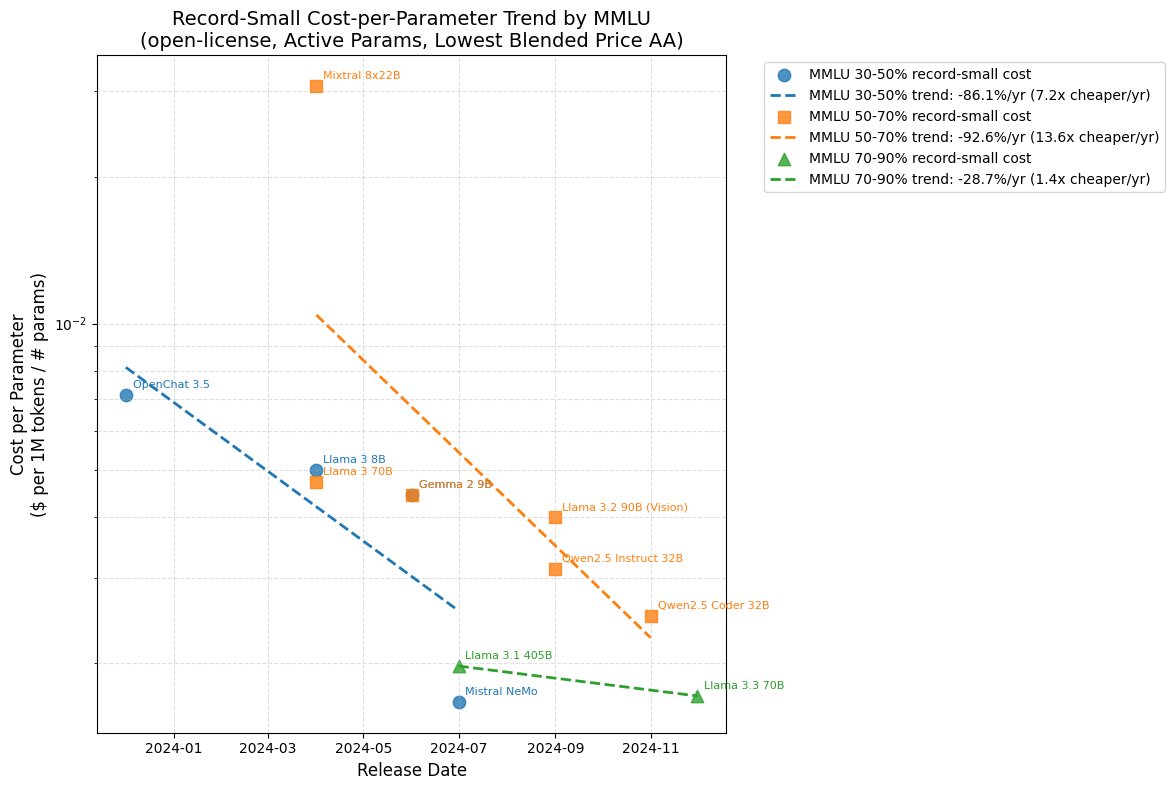

In [27]:
def plot_combined_cost_per_param_trend(open_license_only=False, 
                                     benchmark_name='MMLU-Pro (Reasoning & Knowledge)', 
                                     use_active_params=False, 
                                     price_column='Output Price\nUSD/1M Tokens', 
                                     show_model_names=False):
    """
    Plots record-small cost-per-parameter trends for three MMLU ranges 
    (30-50, 50-70, 70-90) on a single graph.
    
    y-axis = (Price per 1M tokens) / (# of parameters)
    
    Parameters:
    - open_license_only: if True, filter for open-license models.
    - benchmark_name: The benchmark column to use.
    - use_active_params: if True, use 'Active Parameters'; else, 'Parameters'.
    - price_column: The price column to use.
    - show_model_names: if True, annotate record-small points with model names.
    """
    # MMLU ranges and plot styles
    mmlu_ranges = [(30, 50), (50, 70), (70, 90)]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    markers = ['o', 's', '^']

    plt.figure(figsize=(12, 8))

    # Column names
    mmlu_col = benchmark_name
    price_col = price_column
    param_col = 'Active Parameters' if use_active_params else 'Parameters'
    license_col = 'License'

    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        df_work = df.copy()

        # 1) Parse columns to numeric types
        df_work[mmlu_col] = pd.to_numeric(df_work[mmlu_col].astype(str).str.replace('%', '', regex=False), errors='coerce')
        df_work[price_col] = pd.to_numeric(df_work[price_col].astype(str).str.replace('[$,]', '', regex=True), errors='coerce')
        df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')

        # 2) Filter data
        if open_license_only:
            df_work = df_work[df_work[license_col].str.contains('open', case=False, na=False)]
        
        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()
        
        # 3) Drop invalid data and compute cost per parameter
        df_sub = df_sub.dropna(subset=['Release Date', price_col, param_col])
        df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[param_col] > 0)]
        
        if len(df_sub) < 2:
            print(f"Not enough data for MMLU range {min_mmlu}-{max_mmlu} to plot a trend.")
            continue
            
        df_sub['Cost_per_Param'] = df_sub[price_col] / df_sub[param_col]
        
        # 4) Identify record-small points based on cost
        df_sub = df_sub.sort_values('Release Date')
        df_sub['Is_Record_Small'] = df_sub['Cost_per_Param'].cummin() == df_sub['Cost_per_Param']
        record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
        if len(record_small) < 2:
            print(f"Not enough record-small points for MMLU range {min_mmlu}-{max_mmlu} to plot a trend.")
            continue

        # 5) Perform linear regression on log-cost
        record_small['Date_Ordinal'] = record_small['Release Date'].map(datetime.toordinal)
        X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
        y_rec_log = np.log10(record_small['Cost_per_Param'].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)

        # 6) Create prediction data for the trend line
        lo, hi = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(lo, hi + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))

        # 7) Calculate annualized change
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        factor = 1 / (1 + annual_pct_rec/100)
        
        # 8) Plot points and trend line
        label_base = f'MMLU {min_mmlu}-{max_mmlu}%'
        plt.scatter(
            record_small['Release Date'], record_small['Cost_per_Param'],
            color=colors[i], s=80, marker=markers[i], alpha=0.8,
            label=f'{label_base} record-small cost'
        )
        
        plt.plot(
            x_dates, 10**y_rec_log_pred,
            color=colors[i], linestyle='--', linewidth=2,
            label=f'{label_base} trend: {annual_pct_rec:.1f}%/yr ({factor:.1f}x cheaper/yr)'
        )
        
        if show_model_names and 'Model' in record_small.columns:
            for _, row in record_small.iterrows():
                plt.annotate(
                    row['Model'], (row['Release Date'], row['Cost_per_Param']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color=colors[i]
                )

    # 9) Final plot formatting
    plt.yscale('log')
    plt.xlabel('Release Date', fontsize=12)
    plt.ylabel('Cost per Parameter\n($ per 1M tokens / # params)', fontsize=12)
    lic_label = 'open-license' if open_license_only else 'all licenses'
    param_type_label = 'Active' if use_active_params else 'Total'
    price_type_label = price_column.split('\n')[0]
    title = f'Record-Small Cost-per-Parameter Trend by MMLU\n({lic_label}, {param_type_label} Params, {price_type_label})'
    plt.title(title, fontsize=14)
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
# Call the function for open-license models using active parameters and the specified price column.
plot_combined_cost_per_param_trend(
    open_license_only=True, 
    use_active_params=True, 
    price_column="Lowest Blended Price AA",
    show_model_names=True
)

## Naive Overall Trends Using Joint Regression

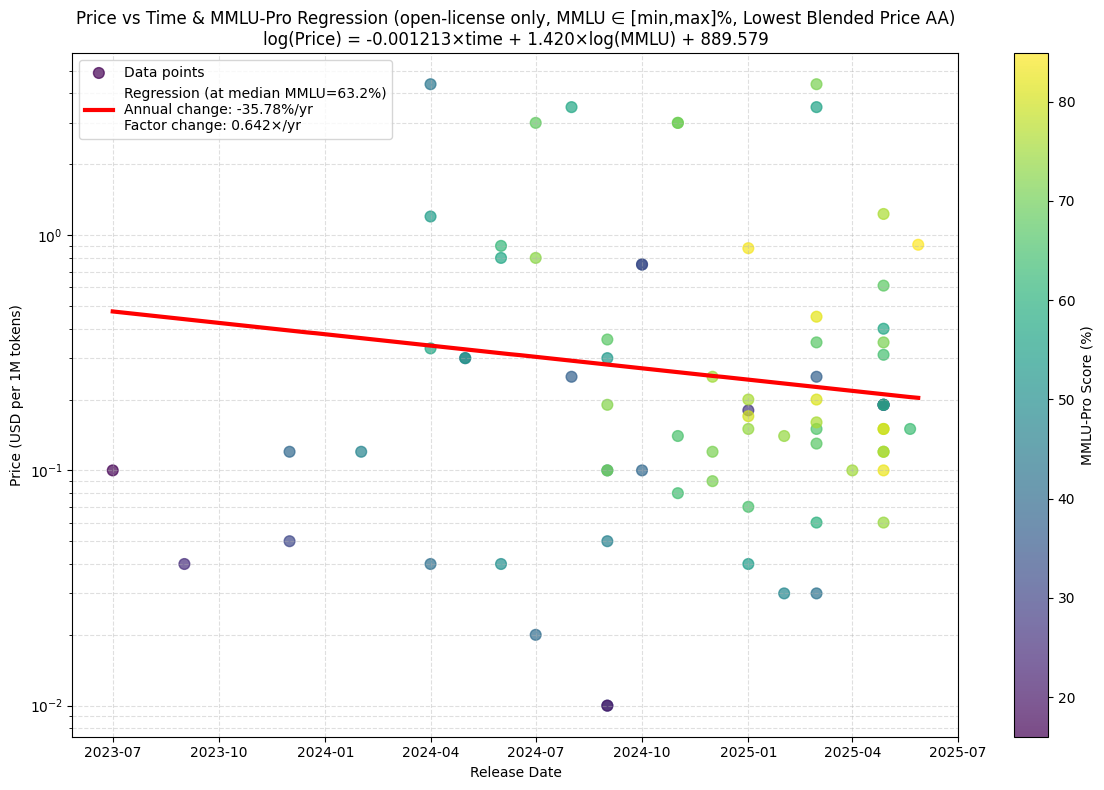


Regression Results:
Model: log(Price) = -0.001213×time + 1.420×log(MMLU) + 889.579
R² score: 0.1117

Time coefficient (alpha): -0.001213
Annual percentage change: -35.78%/yr
Annual factor change: 0.642×/yr
MMLU coefficient (beta): 1.420
Intercept (c): 889.579

Data points used: 75


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime

def plot_price_mmlu_regression(df, open_license_only=False, min_mmlu=None, max_mmlu=None, price_column='Output Price\nUSD/1M Tokens'):
    """
    Plot log(Price) = alpha*time + beta*log(MMLU Pro) + c regression
    
    Parameters:
    - df: DataFrame with the model data
    - open_license_only: If True, only include models with open licenses
    - min_mmlu: Minimum MMLU score to include (default: None)
    - max_mmlu: Maximum MMLU score to include (default: None)
    - price_column: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
    
    Returns fitted model coefficients and annual decrease rates
    """
    # Column names
    mmlu_col = 'MMLU-Pro (Reasoning & Knowledge)'
    price_col = price_column
    license_col = 'License'
    
    # Work on a copy
    df_work = df.copy()
    
    # 1) Convert MMLU "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%', '', regex=False)
                         .astype(float)
    )
    
    # 2) Convert price "$X,XXX" → float
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]', '', regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # 3) Optionally filter to open-license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]
    
    # 4) Filter to rows with all necessary data
    df_sub = df_work.dropna(subset=['Release Date', price_col, mmlu_col])
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[mmlu_col] > 0)]
    
    # 5) Filter by MMLU range if specified
    if min_mmlu is not None:
        df_sub = df_sub[df_sub[mmlu_col] >= min_mmlu]
    if max_mmlu is not None:
        df_sub = df_sub[df_sub[mmlu_col] <= max_mmlu]
    
    if len(df_sub) < 3:
        print(f"Warning: Only {len(df_sub)} data points available. Need at least 3 for regression.")
        return None, None, None
    
    # 6) Prepare variables for regression
    df_sub = df_sub.sort_values('Release Date').copy()
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # Features: time and log(MMLU)
    X = np.column_stack([
        df_sub['Date_Ordinal'].values,
        np.log(df_sub[mmlu_col].values)
    ])
    
    # Target: log(Price)
    y = np.log(df_sub[price_col].values)
    
    # 7) Fit linear regression
    model = LinearRegression().fit(X, y)
    alpha, beta = model.coef_
    c = model.intercept_
    
    # 8) Calculate annual decrease rates
    # alpha is change in log(price) per day, so annual change is alpha * 365
    annual_log_change = alpha * 365
    annual_pct_change = (np.exp(annual_log_change) - 1) * 100
    factor_change_per_year = np.exp(annual_log_change)
    
    # 9) Generate predictions for plotting
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.linspace(min_ord, max_ord, 100)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]
    
    # For visualization, we'll show the trend at median MMLU value
    median_mmlu = df_sub[mmlu_col].median()
    X_pred = np.column_stack([
        x_range,
        np.full(len(x_range), np.log(median_mmlu))
    ])
    y_pred = model.predict(X_pred)
    
    # 10) Plot results
    plt.figure(figsize=(12, 8))
    
    # Color points by MMLU score for better visualization
    scatter = plt.scatter(
        df_sub['Release Date'], 
        df_sub[price_col],
        c=df_sub[mmlu_col], 
        cmap='viridis', 
        alpha=0.7,
        s=60,
        label='Data points'
    )
    
    # Add colorbar for MMLU scores
    cbar = plt.colorbar(scatter)
    cbar.set_label('MMLU-Pro Score (%)')
    
    # Plot regression line (at median MMLU)
    regression_label = (f'Regression (at median MMLU={median_mmlu:.1f}%)\n'
                       f'Annual change: {annual_pct_change:.2f}%/yr\n'
                       f'Factor change: {factor_change_per_year:.3f}×/yr')
    
    plt.plot(x_dates, np.exp(y_pred), 'r-', lw=3, label=regression_label)
    
    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')
    
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    mmlu_range = f"MMLU ∈ [{min_mmlu or 'min'},{max_mmlu or 'max'}]%"
    price_type = price_col.replace('\n', ' ')
    plt.title(f'Price vs Time & MMLU-Pro Regression ({lic_label}, {mmlu_range}, {price_type})\n'
              f'log(Price) = {alpha:.6f}×time + {beta:.3f}×log(MMLU) + {c:.3f}')
    
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nRegression Results:")
    print(f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×log(MMLU) + {c:.3f}")
    print(f"R² score: {model.score(X, y):.4f}")
    print(f"\nTime coefficient (alpha): {alpha:.6f}")
    print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")
    print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
    print(f"MMLU coefficient (beta): {beta:.3f}")
    print(f"Intercept (c): {c:.3f}")
    print(f"\nData points used: {len(df_sub)}")
    
    return model, df_sub, {
        'alpha': alpha,
        'beta': beta, 
        'c': c,
        'annual_pct_change': annual_pct_change,
        'factor_change_per_year': factor_change_per_year,
        'r2_score': model.score(X, y)
    }

# Example usage:
# Assuming df is loaded with your data
model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Blended Price AA")

## Chinese Comparison